### **Modelos RNN de secuencia a secuencia: Tarea de traducción**


En este cuaderno exploraremos los fundamentos de los modelos de secuencia a secuencia y aprenderemos cómo implementar un modelo basado en RNN para una tarea de traducción utilizando PyTorch.


#### Configuración


#### Instalación de las librerías necesarias

<h5 style="color:red;">Después de instalar las librerías que se indican a continuación, por favor REINICIA EL KERNEL y ejecuta todas las celdas.</h5>


In [ ]:
# Todas las librería necesarias para este cuaderno  están listadas a continuación.  

#!mamba install -qy numpy==1.21.4 seaborn==0.9.0  
#**Nota**: Si tu entorno no admite `!mamba install`, utiliza `!pip install`.  

Las siguientes librerías necesarias **no** están preinstaladas en el entorno del curso. **Necesitarás ejecutar la siguiente celda** para instalarlas:  


In [27]:
#!pip install torchtext==0.15.1
#!pip install torch==2.0.0
#!pip install spacy==3.7.2
#!pip install torchdata==0.6.0
#!pip install portalocker>=2.0.0 #2.7.0
#!pip install nltk==3.8.1
#!pip install -U matplotlib

!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 656.4 kB/s eta 0:00:20
     - -------------------------------------- 0.4/12.8 MB 3.0 MB/s eta 0:00:05
     --- ------------------------------------ 1.3/12.8 MB 7.3 MB/s eta 0:00:02
     ------- -------------------------------- 2.4/12.8 MB 10.8 MB/s eta 0:00:01
     --------- ------------------------------ 3.2/12.8 MB 11.9 MB/s eta 0:00:01
     ------------ --------------------------- 4.1/12.8 MB 13.2 MB/s eta 0:00:01
     ----------------- ---------------------- 5.5/12.8 MB 15.4 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 16.3 MB/s eta 0:00:01
     ------------------------ --------------- 7.9/12.8 MB 17.5 MB/s eta 0:00:01
     ---------------------------- ----------- 9.1/12.8 MB 18.1 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
     --------------------------------------- 0.0/14.6 MB 640.0 kB/s eta 0:00:23
     ---------------------------------------- 0.1/14.6 MB 1.1 MB/s eta 0:00:14
     - -------------------------------------- 0.6/14.6 MB 4.3 MB/s eta 0:00:04
     --- ------------------------------------ 1.3/14.6 MB 7.6 MB/s eta 0:00:02
     ------ --------------------------------- 2.2/14.6 MB 10.8 MB/s eta 0:00:02
     --------- ------------------------------ 3.4/14.6 MB 13.6 MB/s eta 0:00:01
     ------------ --------------------------- 4.5/14.6 MB 15.0 MB/s eta 0:00:01
     --------------- ------------------------ 5.6/14.6 MB 16.3 MB/s eta 0:00:01
     ----------------- ---------------------- 6.6/14.6 MB 16.8 MB/s eta 0:00:01
     -------------------- ------------------- 7.6/14.6 MB 17.4 MB/s eta 0:00:01
     ----------------------- ---------------- 8.7/14.6 MB 18.0 MB/s eta 0:00:01
     -------------------------- ------------- 9.7/1


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### **Importación de librerías necesarias**  
_Se recomienda importar todas las librerías necesarias en un solo lugar (aquí):_



In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchdata.datapipes.iter import IterableWrapper, Mapper
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from nltk.translate.bleu_score import sentence_bleu
import torch
import torch.nn as nn
import torch.optim as optim


import numpy as np
import random
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt


# Usamos esta sección para suprimir warnings generados por el codigo:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

c:\Users\KATANA\Desktop\git\Personal\nlp-proyecto11\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **Contexto**

Los modelos de secuencia a secuencia (Seq2seq) han revolucionado varias tareas del procesamiento de lenguaje natural (NLP), como la traducción automática, la generación de resúmenes y los chatbots. Estos modelos utilizan redes neuronales recurrentes (RNNs) para procesar secuencias de entrada de longitud variable y generar secuencias de salida también de longitud variable

#### **Historia de los modelos secuencia a secuencia**

Los modelos secuencia a secuencia fueron introducidos como una extensión de las redes neuronales tradicionales **feedforward**.  Los investigadores reconocieron la necesidad de modelos capaces de manejar entradas y salidas de longitud variable, como en la traducción automática.  

El trabajo pionero de **[Sutskever  (2014)](https://arxiv.org/abs/1409.3215)** introdujo el uso de RNNs en los modelos seq2seq.

Algunos de los principales objetivos de los modelos seq2seq incluyen:

- **Traducción**: traducir una secuencia de un dominio a otro (por ejemplo, de inglés a francés).  
- **Respuesta a preguntas**: generar una respuesta en lenguaje natural dada una oración de entrada (por ejemplo, en un chatbot).  
- **Resumen**: resumir un documento largo en una secuencia corta de oraciones.  

Y muchas más aplicaciones que implican generación de secuencias.


#### **Introducción a las RNN**

Las RNN son una clase de redes neuronales diseñadas para procesar datos secuenciales.  
Mantienen una memoria interna ($h_t$) para capturar información de pasos anteriores y utilizarla en predicciones actuales.  

Las RNN tienen una conexión recurrente que permite que la información fluya de un paso al siguiente.  
Las redes neuronales recurrentes (RNN) operan sobre secuencias y utilizan estados anteriores para influir en el estado actual. Aquí está la formulación general de una RNN simple:

Dado:

- $ \mathbf{x}_t $: vector de entrada en el instante de tiempo $t$

- $ \mathbf{h}_{t-1} $: vector del estado oculto del paso de tiempo anterior

- $ \mathbf{W}_x $ y $ \mathbf{W}_h $: matrices de pesos para la entrada y el estado oculto, respectivamente

- $ \mathbf{b} $: vector de sesgo

- $\sigma$: función de activación (a menudo una sigmoide o tanh)

Las ecuaciones de actualización para el estado oculto $ \mathbf{h}_t $ y la salida $ \mathbf{y}_t $ son las siguientes:

$$
\begin{align*}
\mathbf{h}_t &= \sigma(\mathbf{W}_x \cdot \mathbf{x}_t + \mathbf{W}_h \cdot \mathbf{h}_{t-1} + \mathbf{b})
\end{align*}
$$

Puede verse que la función de estado oculto depende del estado oculto anterior así como de la entrada en el tiempo $t$, por lo que tiene una memoria colectiva de los pasos anteriores.

Para la salida (si estamos haciendo una predicción en cada paso de tiempo):

$$
\begin{align*}
\mathbf{y}_t &= \text{softmax}(\mathbf{W}_o \cdot \mathbf{h}_t + \mathbf{b}_o)
\end{align*}
$$

Donde:

$ \mathbf{W}_o $: matriz de pesos para la salida Y $ \mathbf{b}_o $: vector de sesgo para la salida

Dependiendo de la tarea específica, una celda RNN puede producir una salida desde $h_t$ o simplemente transferirla a la siguiente celda, actuando como memoria interna.  
Aunque la capacidad de la arquitectura para retener memoria pueda parecer esquiva a primera vista, aclaremos esto implementando una RNN simple para manejar el siguiente mecanismo de datos:

![a title](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Screenshot%202023-10-19%20at%2011.29.23%E2%80%AFAM.png)

El diagrama muestra una máquina de estados o modelo de transición con tres estados distintos, representados por los círculos púrpuras prominentes. Cada estado está claramente etiquetado con un valor para $ h $: $ h = -1 $, $ h = 0 $, y $ h = 1 $.

1. **Estado $ h = -1 $**:
   - Se mantiene en sí mismo cuando $ x = 1 $ (ilustrado por el bucle amarillo).
   - Pasa al estado $ h = 0$ al recibir $ x = -1$ (destacado por la flecha roja).

2. **Estado $ h = 0 $**:
   - Se mueve al estado $h = -1 $ cuando $ x = 1$ (ilustrado por la flecha roja).
   - Avanza al estado $ h = 1 $ con $ x = -1$ (marcado por la flecha roja).

3. **Estado $h = 1 $**:
   - Mantiene su posición cuando $ x = -1 $ (indicado por el bucle amarillo).
   - Transiciona al estado $ h = 0 $ al recibir $ x = 1 $ (señalado por la flecha roja).

Para resumir, el diagrama representa eficazmente las transiciones entre tres estados basadas en la entrada $ x $.  
Dependiendo del estado actual y de la entrada $ x $, la máquina de estados transiciona a un estado diferente o permanece estacionaria.

Podemos  representar la máquina de estados mencionada anteriormente utilizando la capa detallada a continuación. Usamos $tanh$ ya que el valor de $h$ debe estar entre `[-1, 1]`. Tenemos en cuenta que hemos excluido la salida para simplificar.

$$\begin{align*}
W_{xh} & = -10.0 \\\\\
W_{hh} & = 10.0 \\
b_h & = 0.0 \\
x_t & = 1 \\
h_{\text{prev}} & = 0.0 \\
h_t & = \tanh(x_t \cdot W_{xh} + h_{\text{prev}} \cdot W_{hh} + b_h)
\end{align*}$$


In [3]:
 W_xh=torch.tensor(-10.0)
 W_hh=torch.tensor(10.0)
 b_h=torch.tensor(0.0)
 x_t=1
 h_prev=torch.tensor(-1)

Consideramos la siguiente secuencia $x_t$ para  $t=0,1,..,7$,


In [4]:
X=[1,1,-1,-1,1,1]

Asumiendo que comenzamos desde el estado inicial $h = 0$ con el vector de entrada $x$ anterior, el vector de estados $h$ debería verse así:


In [5]:
H=[-1,-1,0,1,0,-1]

In [6]:
# Inicializa una lista vacía para almacenar los valores del estado predicho
H_hat = []

# Variable auxiliar para llevar el control del tiempo t
t = 1

# Itera sobre cada punto de datos en la secuencia de entrada X
for x in X:
    # Imprime el instante de tiempo actual
    print("t=", t)
    
    # Asigna el valor del punto de datos actual a x_t
    x_t = x

    # Imprime el valor del estado anterior (h en el tiempo t-1)
    print("h_t-1", h_prev.item())

    # Calcula el estado actual (h en el tiempo t) utilizando la fórmula de la RNN con activación tanh
    h_t = torch.tanh(x_t * W_xh + h_prev * W_hh + b_h)

    # Actualiza h_prev con el estado actual para usarlo en la próxima iteración
    h_prev = h_t

    # Imprime el valor de entrada actual (x en el tiempo t)
    print("x_t", x_t)

    # Imprime el valor del estado actual (h en el tiempo t)
    print("h_t", h_t.item())
    print("\n")

    # Convierte h_t a entero y lo agrega a la lista H_hat
    H_hat.append(int(h_t.item()))

    # Incrementa el tiempo
    t += 1


t= 1
h_t-1 -1
x_t 1
h_t -1.0


t= 2
h_t-1 -1.0
x_t 1
h_t -1.0


t= 3
h_t-1 -1.0
x_t -1
h_t 0.0


t= 4
h_t-1 0.0
x_t -1
h_t 1.0


t= 5
h_t-1 1.0
x_t 1
h_t 0.0


t= 6
h_t-1 0.0
x_t 1
h_t -1.0




Podemos evaluar la precisión del estado predicho ```H_hat``` comparándolo con el estado real ```H```. En las RNN, el estado $ h_t $ se utiliza para predecir una secuencia de salida $ y_t $ basada en la secuencia de entrada dada $ x_t $.


In [7]:
H_hat

[-1, -1, 0, 1, 0, -1]

In [8]:
H

[-1, -1, 0, 1, 0, -1]

Aunque hemos predefinido los valores de $W_{xh}$, $W_{hh}$ y $b_h$, en la práctica estos valores deben ser determinados mediante entrenamiento con datos. 

En la práctica, se utilizan con frecuencia modificaciones y mejoras, como LSTM (Long Short-Term Memory) y GRU (Gated Recurrent Units) para abordar problemas como el desvanecimiento del gradiente en las RNN básicas.


Una celda LSTM tiene tres componentes principales: una puerta de entrada, una puerta de olvido y una puerta de salida.  

- La **puerta de entrada** controla cuánta información nueva debe almacenarse en la memoria de la celda. Observa la entrada actual y el estado oculto anterior y decide qué partes de la nueva entrada deben recordarse.  

- La **puerta de olvido** determina qué información debe descartarse u olvidarse de la memoria de la celda. Considera la entrada actual y el estado oculto anterior y decide qué partes de la memoria anterior ya no son relevantes.  

- La **puerta de salida** determina qué información debe salir de la celda. Observa la entrada actual y el estado oculto anterior y decide qué partes de la memoria de la celda deben incluirse en la salida.

La idea clave detrás de las celdas LSTM es que tienen un estado de memoria separado que puede retener o olvidar información selectivamente con el tiempo. Esto les ayuda a manejar dependencias de largo alcance y recordar información importante de pasos anteriores en una secuencia.

#### **Arquitectura secuencia a secuencia**

Los modelos Seq2seq tienen una estructura de codificador-decodificador. El codificador codifica la secuencia de entrada en una representación de dimensión fija, a menudo llamada vector de contexto ($h_t$). El decodificador genera la secuencia de salida basada en el vector de contexto codificado.

Veamos más de cerca las cajas del codificador y decodificador en el video a continuación. La traducción es una tarea típica de secuencia a secuencia. La entrada es una secuencia de palabras en el idioma original ("I love to travel"), mientras que la salida es su traducción en el idioma de destino ("J'adore voyager"). 

Como se muestra en el video, la entrada se alimenta a la parte del decodificador, una palabra tras otra. Cada celda RNN recibe una palabra ($x_t$) y tiene una memoria interna ($h_t$). Después de procesar la entrada y $h_t$, la celda RNN pasa un vector de contexto actualizado ($h_{t+1}$) a la siguiente celda RNN. Cuando se alcanza el final de la oración, el vector de contexto se pasa a la parte del decodificador. Las celdas del decodificador también son celdas RNN que reciben el vector de contexto y generan la salida palabra por palabra. 

Cada RNN recibe la palabra generada así como el vector de contexto actualizado de su celda anterior y genera la siguiente palabra ($y_t$). Esta arquitectura permite generar texto sin restricciones de longitud.


<video width="640" height="480"
src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Translation_RNN.mp4"
controls>
</video>


#### Implementación del codificador en PyTorch

Para implementar la parte del codificador usando PyTorch, crearemos una subclase de la clase `torch.nn.Module` y definiremos los métodos `__init__()` y `__forward__()`.

Primero, definamos los parámetros que se utilizan en la función `__init__()`:
- `vocab_len` no es más que el número de palabras únicas presentes en el vocabulario. Después de preprocesar los datos, podemos contar el número de palabras únicas en el vocabulario y usar ese conteo aquí. Esta será la dimensión de entrada del modelo.
- `embedding_dim` es la dimensión de salida del vector de embedding que se necesita. Una buena práctica es usar valores entre 256 y 512 para una aplicación de demostración como la que estamos construyendo aquí.
- LSTM puede apilarse, lo que permite múltiples capas. En la implementación inicial, usaremos solo una capa. Sin embargo, para permitir flexibilidad futura, pasaremos el parámetro `n_layers` para especificar el número de capas en el LSTM.
- `hid_dim` es la dimensionalidad de los estados oculto y de celda.
- `dropout` es la cantidad de *dropout* a utilizar. Este es un parámetro de regularización para evitar el sobreajuste.

Ahora, veamos las capas:
- La capa de *Embedding* toma los datos de entrada y genera el vector de embedding; por lo tanto, su dimensión debe definirse como `vocab_len` y `embedding_dim`.
- La capa LSTM toma `embedding_dim` como datos de entrada y genera un total de 3 salidas: `hidden`, `cell` y `output`. Aquí debemos definir el número de neuronas que necesitas en el LSTM, lo cual se especifica con `hid_dim`.

En la función `__forward__()`, se define la capa de *Embedding* que utiliza `vocab_len` para convertir internamente `input_batch` en una representación one-hot. Luego, la capa LSTM recibe la entrada embebida y devuelve tres vectores: *Output*, *Hidden* y *Cell*. En el caso del codificador, no necesitaremos el vector de salida del LSTM, ya que solo pasaremos el vector de contexto (`hidden` + `cell`) al bloque del decodificador. Por lo tanto, `forward()` solo devuelve `hidden` y `cell`.

**Nota**: Al usar un LSTM, disponemos de un estado de celda adicional. Sin embargo, si utilizamos un GRU, solo tendríamos el estado oculto.

In [9]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, emb_dim, hid_dim, n_layers, dropout_prob):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # Capa de embedding: convierte índices de palabras en vectores de embedding
        self.embedding = nn.Embedding(vocab_len, emb_dim)

        # Capa LSTM: recibe embeddings y genera salidas y estados
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout_prob)

        # Capa de dropout para regularización
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        # input_batch = [longitud de la secuencia fuente, tamaño del lote]

        # Aplica embedding seguido de dropout
        embed = self.dropout(self.embedding(input_batch))
        embed = embed.to(device)

        # outputs = [longitud de la secuencia fuente, tamaño del lote, dimensión oculta * número de direcciones]
        # hidden = [número de capas * número de direcciones, tamaño del lote, dimensión oculta]
        # cell = [número de capas * número de direcciones, tamaño del lote, dimensión oculta]
        outputs, (hidden, cell) = self.lstm(embed)

        return hidden, cell


Ahora estamos listo para crear una instancia del codificador y ver cómo funciona.


In [10]:
vocab_len = 8
emb_dim = 10
hid_dim=8
n_layers=1
dropout_prob=0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_t = Encoder(vocab_len, emb_dim, hid_dim, n_layers, dropout_prob).to(device)

Veamos un ejemplo simple donde el método `forward` del codificador transforma la oración `src` en los estados `hidden` y `cell`.  

El tensor `tensor([[0],[3],[4],[2],[1]])` es equivalente a `src` = 0,3,4,2,1, en el cual cada número representa un token en el vocabulario de `src`.  

Por ejemplo: 0:`<bos>`, 3:"Das", 4:"ist", 2:"schön", 1:`<eos>`.  

Tenemos un tamaño de lote (*batch size*) de 1.

In [11]:
src_batch = torch.tensor([[0,3,4,2,1]])
# Necesitas transponer el tensor de entrada ya que el LSTM del codificador está en modo "secuencia primero" por defecto
src_batch = src_batch.t().to(device)
print("Forma del tensor de entrada (src):", src_batch.shape)
hidden_t , cell_t = encoder_t(src_batch)
print("Tensor oculto (hidden) del codificador:", hidden_t, "\nTensor de celda (cell) del codificador:", cell_t)

Forma del tensor de entrada (src): torch.Size([5, 1])
Tensor oculto (hidden) del codificador: tensor([[[ 0.0278, -0.0581,  0.0761, -0.1401, -0.3128,  0.0406, -0.0140,
          -0.0827]]], grad_fn=<StackBackward0>) 
Tensor de celda (cell) del codificador: tensor([[[ 0.0671, -0.1164,  0.1947, -0.3121, -0.7701,  0.0818, -0.0313,
          -0.2240]]], grad_fn=<StackBackward0>)


El codificador toma toda la secuencia de origen como entrada, la cual consiste en una secuencia de palabras o tokens. El LSTM del codificador procesa toda la secuencia de entrada y actualiza sus estados ocultos en cada paso de tiempo. Los estados ocultos de la red LSTM actúan como una forma de memoria y capturan la información contextual de la secuencia de entrada. Después de procesar toda la secuencia de entrada, el estado oculto final del LSTM del codificador captura la representación resumida del contexto de la secuencia de entrada. Este estado oculto final a veces se conoce como  **vector de contexto**.


#### Implementación del decodificador en PyTorch

Para comprender mejor el mecanismo interno de la parte del decodificador, echemos un vistazo más detallado:


<video width="640" height="480"
       src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/decoder_RNN.mp4"
       controls>
</video>


La clase del decodificador hereda de `nn.Module`, que es la clase base para todos los módulos de redes neuronales en PyTorch.  
El constructor (método `__init__`) inicializa los parámetros y las capas del decodificador.

- `output_dim` es el número de posibles valores de salida (longitud del vocabulario objetivo).  
- `emb_dim` es la dimensionalidad de la capa de embeddings.  
- `hid_dim` es la dimensionalidad del estado oculto en la LSTM.  
- `n_layers` es el número de capas en la LSTM.  
- `dropout` es la probabilidad de aplicar *dropout*.

El decodificador contiene las siguientes capas:

- `embedding`: Una capa de *embedding* que mapea los valores de salida a vectores densos de tamaño `emb_dim`.  
- `lstm`: Una capa LSTM que toma la entrada embebida y produce estados ocultos de tamaño `hid_dim`.  
- `fc_out`: Una capa lineal que mapea la salida de la LSTM a la dimensión de salida `output_dim`.  
- `softmax`: Una función de activación *log-softmax* que se aplica a la salida para obtener una distribución de probabilidad sobre los posibles valores de salida.  
- `dropout`: Una capa de *dropout* que aplica *dropout* a la entrada embebida.

In [12]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # Capa de embedding para convertir índices en vectores densos
        self.embedding = nn.Embedding(output_dim, emb_dim)

        # Capa LSTM que procesa la secuencia embebida
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

        # Capa totalmente conectada que proyecta a la dimensión del vocabulario
        self.fc_out = nn.Linear(hid_dim, output_dim)

        # Capa de softmax logarítmica para obtener probabilidades
        self.softmax = nn.LogSoftmax(dim=1)

        # Capa de dropout para regularización
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):

        # input = [tamaño del lote]

        # hidden = [n capas * n direcciones, tamaño del lote, dim oculta]
        # cell = [n capas * n direcciones, tamaño del lote, dim oculta]

        # En el decodificador, el número de direcciones siempre será 1, por lo tanto:
        # hidden = [n capas, tamaño del lote, dim oculta]
        # cell = [n capas, tamaño del lote, dim oculta]

        # Añade una dimensión de secuencia (tamaño 1) al input
        input = input.unsqueeze(0)
        # input = [1, tamaño del lote]

        # Aplica embedding y dropout
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, tamaño del lote, dim embedding]

        # Pasa por la LSTM
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output = [long secuencia, tamaño del lote, dim oculta * n direcciones]
        # hidden = [n capas * n direcciones, tamaño del lote, dim oculta]
        # cell = [n capas * n direcciones, tamaño del lote, dim oculta]

        # Como la longitud de la secuencia y el número de direcciones son 1:
        # output = [1, tamaño del lote, dim oculta]
        # hidden = [n capas, tamaño del lote, dim oculta]
        # cell = [n capas, tamaño del lote, dim oculta]

        # Aplica capa lineal y softmax logarítmico para obtener la predicción
        prediction_logit = self.fc_out(output.squeeze(0))
        prediction = self.softmax(prediction_logit)
        # prediction = [tamaño del lote, dimensión de salida]

        return prediction, hidden, cell


Podemos crear una instancia del decodificador. La dimensión de salida se establece como la longitud del vocabulario objetivo.

In [13]:
output_dim = 6
emb_dim=10
hid_dim = 8
n_layers=1
dropout=0.5
decoder_t = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout).to(device)

Ahora que tenemos instancias tanto del codificador como del decodificador, estamos listo para conectarlos (la caja roja en el diagrama a continuación). Primero, veamos cómo podemos pasar los estados *Hidden* y *Cell* (la celda rosada dentro de la caja roja) del codificador (el contenedor de cajas verdes) al decodificador (el contenedor de cajas naranjas). 

Al observar el diagrama, podemos ver que el decodificador también recibe una entrada, que es la palabra previa que ha predicho. Para la primera celda del decodificador, esta entrada es el token `<bos>`. Cada celda del decodificador genera una predicción y actualiza la celda y el estado para pasarlos a la siguiente celda del decodificador. La predicción es una distribución de probabilidad sobre los posibles tokens del idioma objetivo (longitud del vocabulario objetivo).

![connection](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/ED_connection.JPG)


In [14]:
input_t = torch.tensor([0]).to(device) #<bos>
input_t.shape
prediction, hidden, cell = decoder_t(input_t, hidden_t , cell_t)
print("Prediccion:", prediction, '\nOculto:',hidden,'\nCelda:', cell)

Prediccion: tensor([[-1.4125, -2.0433, -1.8859, -1.8616, -1.7628, -1.9092]],
       grad_fn=<LogSoftmaxBackward0>) 
Oculto: tensor([[[ 0.3972,  0.0299,  0.1421, -0.0157, -0.4288, -0.1622,  0.1460,
          -0.4024]]], grad_fn=<StackBackward0>) 
Celda: tensor([[[ 0.5928,  0.0976,  0.5565, -0.0256, -0.8387, -0.2355,  0.3070,
          -0.6330]]], grad_fn=<StackBackward0>)


#### Conexión codificador-decodificador 


Aprendimos cómo crear los módulos del codificador y del decodificador y cómo pasarles entradas. Ahora necesitamos crear la conexión para que el modelo pueda procesar pares (`src`, `trg`) y generar la traducción. Supongamos que `trg` es el tensor `([[0],[2],[3],[5],[1]])`, lo cual es equivalente a la secuencia 0,2,3,5,1, en la que cada número representa un token en el vocabulario objetivo.

Por ejemplo: 0:`<bos>`, 2:"this", 3:"is", 5:"beautiful", 1:`<eos>`.


In [15]:
# trg = [longitud de trg, tamaño del lote]
# teacher_forcing_ratio es la probabilidad de usar teacher forcing
# por ejemplo, si teacher_forcing_ratio es 0.75, usas entradas reales (ground-truth) el 75% del tiempo
teacher_forcing_ratio = 0.5
trg = torch.tensor([[0],[2],[3],[5],[1]]).to(device)

# Obtiene el tamaño del lote desde la dimensión 1 de trg
batch_size = trg.shape[1]

# Obtiene la longitud de la secuencia trg
trg_len = trg.shape[0]

# Obtiene el tamaño del vocabulario de salida del decodificador
trg_vocab_size = decoder_t.output_dim

# Tensor para almacenar las salidas del decodificador
outputs_t = torch.zeros(trg_len, batch_size, trg_vocab_size).to(device)

# Envía los tensores hidden y cell al dispositivo (CPU o GPU)
hidden_t = hidden_t.to(device)
cell_t = cell_t.to(device)

# la primera entrada para el decodificador es el token <bos>
input = trg[0, :]

# Bucle sobre la longitud de la secuencia de salida
for t in range(1, trg_len):

    # Se recorre la longitud de trg y se generan tokens
    # El decodificador recibe el token anterior generado, el estado de celda y el estado oculto
    # El decodificador produce la predicción (distribución de probabilidad del siguiente token) y actualiza hidden y cell
    output_t, hidden_t, cell_t = decoder_t(input, hidden_t, cell_t)

    # Guarda la predicción en el tensor que almacena las salidas del decodificador
    outputs_t[t] = output_t

    # Decide si se usará teacher forcing
    teacher_force = random.random() < teacher_forcing_ratio

    # Obtiene el token con mayor probabilidad entre las predicciones
    top1 = output_t.argmax(1)

    # Si se usa teacher forcing, se utiliza el token real como siguiente entrada
    # Si no, se utiliza el token predicho
    input = trg[t] if teacher_force else top1

# Muestra las salidas del decodificador y su forma
print(outputs_t, outputs_t.shape)


tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[-1.6918, -1.9462, -1.7970, -1.6791, -1.7657, -1.8999]],

        [[-1.7665, -1.9269, -1.6018, -1.9447, -1.5759, -2.0242]],

        [[-1.6188, -1.9920, -1.8239, -1.8633, -1.6643, -1.8353]],

        [[-1.8061, -1.9035, -1.4794, -1.8988, -1.7580, -1.9897]]],
       grad_fn=<CopySlices>) torch.Size([5, 1, 6])


El tamaño del tensor de salida es `(trg_len, batch_size, trg_vocab_size)`. Esto se debe a que, para cada token de `trg` (longitud de `trg`), el modelo genera una distribución de probabilidad sobre todos los posibles tokens (longitud del vocabulario de `trg`). Por lo tanto, para generar los tokens predichos o la traducción de la oración `src`, necesitas obtener la probabilidad máxima para cada token:

In [16]:
# Ten en cuenta que necesitamos obtener el `argmax` de la segunda dimensión, ya que **outputs** es un 
# arreglo de tensores de **salida**.
pred_tokens = outputs_t.argmax(2)
print(pred_tokens)

tensor([[0],
        [3],
        [4],
        [0],
        [2]])


No es sorprendente que la traducción no sea correcta (`trg = tensor([[0],[2],[3],[5],[1]])`), ya que el modelo aún no ha pasado por ningún entrenamiento. Vamos a reunir todo el código para conectar el codificador y el decodificador en una clase `seq2seq` para una mejor usabilidad.


#### Implementación del modelo secuencia a secuencia en PyTorch

Vamos a conectar los componentes del codificador y el decodificador para crear el modelo `seq2seq`.

Se define la clase `seq2seq` que hereda de `nn.Module`, la cual es la clase base para todos los módulos de redes neuronales en PyTorch. 

Los parámetros de entrada son:

- `encoder` y `decoder` son instancias de las redes de codificador y decodificador que ya has definido.  
- `device` especifica el dispositivo (por ejemplo, CPU o GPU) en el que se realizarán los cálculos.  
- `trg_vocab` representa el vocabulario del idioma objetivo. Se utiliza para determinar el tamaño del vocabulario de salida.  

El método **forward** define el paso hacia adelante del modelo `seq2seq`. Recibe tres argumentos: `src`, `trg` y `teacher_forcing_ratio`:

- `src` representa las secuencias de entrada, y `trg` representa las secuencias de destino.  
- `teacher_forcing_ratio` es una probabilidad que determina si se utilizará *teacher forcing* solo durante el entrenamiento. *Teacher forcing* es una técnica en la cual la secuencia de destino real se alimenta como entrada al decodificador en cada paso de tiempo, en lugar de usar la salida predicha del paso anterior.

El método **forward** inicializa algunas variables necesarias para el paso hacia adelante, como `batch_size`, `trg_len` y `trg_vocab_size`. También crea un tensor vacío llamado `outputs` para almacenar las salidas del decodificador en cada paso de tiempo.

Los estados `hidden` y `cell` del codificador se obtienen llamando al método del codificador con `src` como entrada. Estos estados se utilizan como los estados iniciales del decodificador.

La entrada al decodificador en el primer paso de tiempo es el token `<bos>` de las secuencias objetivo.

Se itera sobre el decodificador para cada paso de tiempo en las secuencias objetivo (`for t in range(1, trg_len)`). La entrada, junto con los estados `hidden` y `cell` anteriores, se pasa al decodificador, y este genera un tensor de salida. El tensor `output` se almacena en el tensor `outputs`.

En cada paso de tiempo, se toma una decisión sobre si usar o no *teacher forcing* en función de la probabilidad `teacher_forcing_ratio`. Si se utiliza *teacher forcing*, el siguiente token real de la secuencia objetivo (`trg[t]`) se usa como entrada para el siguiente paso. De lo contrario, se usa el token predicho en el paso anterior (`top1 = output.argmax(1)`).

Finalmente, se devuelve el tensor `outputs` que contiene las salidas predichas para cada paso de tiempo.

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, trg_vocab):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.trg_vocab = trg_vocab

        # Asegúrate de que las dimensiones ocultas del codificador y del decodificador sean iguales
        assert encoder.hid_dim == decoder.hid_dim, \
            "¡Las dimensiones ocultas del codificador y del decodificador deben ser iguales!"
        # Asegúrate de que ambos tengan el mismo número de capas
        assert encoder.n_layers == decoder.n_layers, \
            "¡El codificador y el decodificador deben tener el mismo número de capas!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        # src = [longitud de src, tamaño del lote]
        # trg = [longitud de trg, tamaño del lote]
        # teacher_forcing_ratio es la probabilidad de usar teacher forcing
        # por ejemplo, si teacher_forcing_ratio es 0.75, usas la entrada real el 75% del tiempo

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # Tensor para almacenar las salidas del decodificador
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # El último estado oculto del codificador se usa como estado inicial del decodificador
        hidden, cell = self.encoder(src)
        hidden = hidden.to(device)
        cell = cell.to(device)

        # la primera entrada del decodificador son los tokens <bos>
        input = trg[0, :]

        for t in range(1, trg_len):

            # Inserta el embedding del token de entrada, estado oculto y de celda anteriores
            # Recibe el tensor de salida (predicciones) y los nuevos estados oculto y de celda
            output, hidden, cell = self.decoder(input, hidden, cell)

            # Guarda las predicciones en un tensor que almacena las predicciones para cada token
            outputs[t] = output

            # Decide si se va a usar teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Obtiene el token con mayor probabilidad de las predicciones
            top1 = output.argmax(1)

            # Si se usa teacher forcing, usa el siguiente token real como entrada
            # Si no, usa el token predicho
            input = trg[t] if teacher_force else top1

        return outputs


#### Entrenamiento del modelo en PyTorch

Ahora que el modelo está definido, se define una función de entrenamiento para el modelo `seq2seq`. 
Veamos el código y comprendamos sus componentes:

1. `train(modelo, iterator, optimizer, criterion, clip)` recibe cinco argumentos:

   - `modelo` es el modelo que será entrenado.  
   - `iterator` es un objeto iterable que proporciona los datos de entrenamiento en lotes.  
   - `optimizer` es el algoritmo de optimización utilizado para actualizar los parámetros del modelo.  
   - `criterion` es la función de pérdida que mide el desempeño del modelo.  
   - `clip` es un valor utilizado para limitar los gradientes y evitar que se vuelvan demasiado grandes durante la retropropagación.

2. La función comienza estableciendo el modelo en modo entrenamiento con `modelo.train()`. Esto es necesario para habilitar ciertas capas (por ejemplo, *dropout*) que se comportan de forma distinta durante el entrenamiento y la evaluación.

3. Se inicializa una variable `epoch_loss` para llevar el control de la pérdida acumulada durante la época.

4. La función itera sobre los datos de entrenamiento proporcionados por el `iterator`. Cada iteración recupera un lote de secuencias de entrada (`src`) y secuencias objetivo (`trg`).

5. Las secuencias de entrada (`src`) y las secuencias objetivo (`trg`) se envían al dispositivo correspondiente (por ejemplo, GPU) usando `src = src.to(device)` y `trg = trg.to(device)`.

6. Se limpian los gradientes de los parámetros del modelo usando `optimizer.zero_grad()` para preparar el modelo para el nuevo lote.

7. Luego se llama al modelo con `output = modelo(src, trg)` para obtener las predicciones del modelo sobre las secuencias objetivo.

8. El tensor `output` tiene dimensiones `[trg len, batch size, output dim]`. Para calcular la pérdida, el tensor se reestructura como `[trg len - 1, batch size, output dim]` para eliminar el token inicial `<bos>`, que no se utiliza en el cálculo de la pérdida.

9. Las secuencias objetivo (`trg`) también se reestructuran como `[trg len - 1]`, eliminando el token inicial `<bos>` y convirtiéndolas en un tensor contiguo. Esto permite que coincidan con la forma del tensor `output` reestructurado.

10. La pérdida entre los tensores `output` y `trg` reestructurados se calcula usando la función de pérdida especificada (`criterion`).

11. Se calculan los gradientes de la pérdida con respecto a los parámetros del modelo usando `loss.backward()`.

12. Luego, los gradientes se limitan a un valor máximo especificado por `clip` usando `torch.nn.utils.clip_grad_norm_(modelo.parameters(), clip)`. Esto previene que los gradientes se vuelvan demasiado grandes, lo cual puede causar problemas durante la optimización.

13. Se llama al método `step()` del optimizador para actualizar los parámetros del modelo utilizando los gradientes calculados.

14. La pérdida actual del lote (`loss.item()`) se agrega a la variable `epoch_loss`.

15. Una vez que todos los lotes han sido procesados, la función devuelve la pérdida promedio por lote durante toda la época, calculada como `epoch_loss / len(list(iterator))`.

In [18]:
def train(modelo, iterator, optimizer, criterion, clip):

    # Establece el modelo en modo de entrenamiento
    modelo.train()

    # Inicializa la pérdida acumulada de la época
    epoch_loss = 0

    # Envuelve el iterador con tqdm para mostrar el progreso durante el entrenamiento
    train_iterator = tqdm(iterator, desc="Entrenando", leave=False)

    # Itera sobre los lotes del conjunto de entrenamiento
    for i, (src, trg) in enumerate(iterator):

        # Envía los datos al dispositivo (CPU o GPU)
        src = src.to(device)
        trg = trg.to(device)

        # Reinicia los gradientes del optimizador
        optimizer.zero_grad()

        # Ejecuta el modelo sobre las secuencias de entrada y objetivo
        output = modelo(src, trg)

        # trg = [longitud de trg, tamaño del lote]
        # output = [longitud de trg, tamaño del lote, dimensión de salida]

        output_dim = output.shape[-1]

        # Excluye el primer token (<bos>) de la salida y reestructura el tensor
        output = output[1:].view(-1, output_dim)

        # Excluye también el primer token (<bos>) de trg y lo convierte en un tensor contiguo plano
        trg = trg[1:].contiguous().view(-1)

        # trg = [(longitud de trg - 1) * tamaño del lote]
        # output = [(longitud de trg - 1) * tamaño del lote, dimensión de salida]

        # Calcula la pérdida entre la salida del modelo y el valor real
        loss = criterion(output, trg)

        # Propagación hacia atrás: calcula los gradientes
        loss.backward()

        # Aplica recorte de gradientes para evitar explosiones de gradientes
        torch.nn.utils.clip_grad_norm_(modelo.parameters(), clip)

        # Actualiza los parámetros del modelo
        optimizer.step()

        # Actualiza la barra de progreso de tqdm con la pérdida actual
        train_iterator.set_postfix(loss=loss.item())

        # Acumula la pérdida del lote actual
        epoch_loss += loss.item()

    # Devuelve la pérdida promedio por lote en toda la época
    return epoch_loss / len(list(iterator))


#### Evaluación del modelo en PyTorch

También necesitamos definir una función para evaluar el modelo. Veamos el código y comprendamos sus componentes:

1. `evaluate(modelo, iterator, criterion)` recibe tres argumentos:
   - `modelo` es el modelo de red neuronal que será evaluado.  
   - `iterator` es un objeto iterable que proporciona los datos de evaluación en lotes.  
   - `criterion` es la función de pérdida que mide el desempeño del modelo.  
   * Nota: la función `evaluate` no realiza ninguna optimización sobre el modelo.

2. La función comienza estableciendo el modelo en modo evaluación con `modelo.eval()`.

3. Se inicializa una variable `epoch_loss` para llevar un registro de la pérdida acumulada durante la evaluación.

4. La función entra en un bloque `with torch.no_grad()`, lo cual garantiza que no se calculen gradientes durante la evaluación. Esto ahorra memoria y acelera el proceso, ya que los gradientes no se necesitan para actualizar los parámetros.

5. La función itera sobre los datos de evaluación proporcionados por el `iterator`. Cada iteración recupera un lote de secuencias de entrada (`src`) y secuencias objetivo (`trg`).

6. Las secuencias de entrada (`src`) y las secuencias objetivo (`trg`) se mueven al dispositivo correspondiente (por ejemplo, GPU) usando `src = src.to(device)` y `trg = trg.to(device)`.

7. Luego se llama al modelo con `output = modelo(src, trg, 0)` para obtener las predicciones del modelo sobre las secuencias objetivo. El tercer argumento `0` se pasa para indicar que el *teacher forcing* está desactivado durante la evaluación. Generalmente, el *teacher forcing* se desactiva en la evaluación para observar la capacidad del modelo de generar secuencias a partir de sus propias predicciones.

8. El tensor `output` tiene dimensiones `[trg len, batch size, output dim]`. Para calcular la pérdida, el tensor se reestructura a `[trg len - 1, batch size, output dim]` para eliminar el token inicial `<bos>` (inicio de secuencia), que no se utiliza para el cálculo de la pérdida.

9. Las secuencias objetivo (`trg`) también se reestructuran a `[trg len - 1]`, eliminando el token inicial `<bos>` y convirtiéndolas en un tensor contiguo. Esto permite que coincidan con la forma del tensor `output` reestructurado.

10. La pérdida entre los tensores `output` y `trg` reestructurados se calcula usando el `criterion` especificado.

11. La pérdida del lote actual (`loss.item()`) se suma a la variable `epoch_loss`.

12. Una vez que todos los lotes han sido procesados, la función devuelve la pérdida promedio por lote durante toda la evaluación, calculada como `epoch_loss / len(list(iterator))`.

In [19]:
def evaluate(modelo, iterator, criterion):

    # Establece el modelo en modo evaluación
    modelo.eval()

    # Inicializa la pérdida acumulada de la época
    epoch_loss = 0

    # Envuelve el iterador con tqdm para mostrar el progreso durante la evaluación
    valid_iterator = tqdm(iterator, desc="Evaluando", leave=False)

    # Desactiva el cálculo de gradientes para ahorrar memoria y acelerar la evaluación
    with torch.no_grad():

        # Itera sobre los lotes del conjunto de evaluación
        for i, (src, trg) in enumerate(iterator):

            # Envía los datos al dispositivo (CPU o GPU)
            src = src.to(device)
            trg = trg.to(device)

            # Ejecuta el modelo con teacher forcing desactivado
            output = modelo(src, trg, 0)  # desactiva el teacher forcing

            # trg = [longitud de trg, tamaño del lote]
            # output = [longitud de trg, tamaño del lote, dimensión de salida]

            output_dim = output.shape[-1]

            # Excluye el primer token (<bos>) y reestructura la salida
            output = output[1:].view(-1, output_dim)

            # Excluye también el primer token (<bos>) de trg y lo convierte en tensor plano
            trg = trg[1:].contiguous().view(-1)

            # trg = [(longitud de trg - 1) * tamaño del lote]
            # output = [(longitud de trg - 1) * tamaño del lote, dimensión de salida]

            # Calcula la pérdida entre la salida del modelo y el valor real
            loss = criterion(output, trg)

            # Actualiza la barra de progreso de tqdm con la pérdida actual
            valid_iterator.set_postfix(loss=loss.item())

            # Acumula la pérdida del lote actual
            epoch_loss += loss.item()

    # Devuelve la pérdida promedio por lote durante la evaluación
    return epoch_loss / len(list(iterator))


#### Preprocesamiento de datos

En esta sección, descargaremos un conjunto de datos de traducción de idiomas llamado **Multi30k**, lo procesaremos (tokenización, conversión a números, y adición de tokens BOS/EOS y padding), y crearemos lotes iterables de tensores `src` y `trg`.

Esto aprovecha la función `collate_fn` predefinida para preparar de manera eficiente los lotes que se usarán en el entrenamiento del modelo *transformer*. El objetivo principal es profundizar en los detalles de los componentes codificador y decodificador basados en RNN. 

Se ha creado un archivo llamado **"Multi30K_de_en_dataloader.py"** que contiene todos los procesos de transformación sobre los datos.  

Aquí, solo debemos descargar el archivo:


In [25]:
import requests

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py"
filename = "Multi30K_de_en_dataloader.py"

response = requests.get(url)

if response.status_code == 200:
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"Archivo '{filename}' descargado correctamente.")
else:
    print(f"Error al descargar el archivo. Código de estado: {response.status_code}")


Archivo 'Multi30K_de_en_dataloader.py' descargado correctamente.


In [23]:
# !curl 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Multi30K_de_en_dataloader.py'

curl: (3) URL rejected: Port number was not a decimal number between 0 and 65535


Lo ejecutamos:


In [28]:
%run Multi30K_de_en_dataloader.py

Solo necesitamos llamar a la función `get_translation_dataloaders(batch_size = N, flip=True)` con un tamaño de lote arbitrario `N` y configurando `flip` en `True` para que el codificador LSTM reciba la secuencia de entrada en orden inverso. 

Esto puede ayudar al entrenamiento.


In [29]:
train_dataloader, valid_dataloader = get_translation_dataloaders(batch_size = 4)#,flip=True)

Verificamos los tensores `src` y `trg`:


In [30]:
src, trg = next(iter(train_dataloader))
src,trg

(tensor([[    2,     2,     2,     2],
         [    3,  5510,  5510, 12642],
         [    1,     3,     3,     8],
         [    1,     1,     1,  1701],
         [    1,     1,     1,     3]]),
 tensor([[   2,    2,    2,    2],
         [   3, 6650,  216,    6],
         [   1, 4623,  110, 3398],
         [   1,  259, 3913,  202],
         [   1,  172, 1650,  109],
         [   1, 9953, 3823,   37],
         [   1,  115,   71,    3],
         [   1,  692, 2808,    1],
         [   1, 3428, 2187,    1],
         [   1,    5,    5,    1],
         [   1,    3,    3,    1]]))

También podemos obtener las cadenas en inglés y alemán utilizando las funciones `index_to_eng` e `index_to_german` que se proporcionan en el archivo `.py`.


In [31]:
data_itr = iter(train_dataloader)

# Avanzamos en el conjunto de datos para alcanzar secuencias de mayor longitud con fines ilustrativos.
# (Recordemos que el conjunto de datos está ordenado por longitud de secuencia para un padding óptimo)
for n in range(1000):
    german, english = next(data_itr)

for n in range(3):
    german, english = next(data_itr)
    german = german.T
    english = english.T
    print("________________")
    print("Alemán")
    for g in german:
        print(index_to_german(g))
    print("________________")
    print("Inglés")
    for e in english:
        print(index_to_eng(e))


________________
Alemán
<bos> Personen mit schwarzen Hüten in der Innenstadt . <eos>
<bos> Eine Gruppe Menschen protestiert in einer Stadt . <eos>
<bos> Eine Gruppe teilt ihre politischen Ansichten mit . <eos>
<bos> Mehrere Personen sitzen an einem felsigen Strand . <eos>
________________
Inglés
<bos> People in black hats gathered together downtown . <eos> <pad> <pad> <pad>
<bos> A group of people protesting in a city . <eos> <pad> <pad>
<bos> A group is letting their political opinion be known . <eos> <pad>
<bos> A group of people are sitting on a rocky beach . <eos>
________________
Alemán
<bos> Zwei sitzende Personen mit Hüten und Sonnenbrillen . <eos>
<bos> Ein kleiner Junge mit Hut beim Angeln . <eos>
<bos> Diese zwei Frauen haben Spaß im Giorgio's . <eos>
<bos> Zwei kleine Kinder schlafen auf dem Sofa . <eos>
________________
Inglés
<bos> Two people sitting in hats and shades . <eos> <pad> <pad> <pad>
<bos> A young boy in a hat is fishing by himself . <eos>
<bos> These two women 

* Nota: Al trabajar con tensores de PyTorch que representan datos, es importante comprender las convenciones relacionadas con la representación de secuencias. En la mayoría de los casos, las filas (la primera dimensión) de un tensor de PyTorch representan muestras individuales, mientras que las columnas (la segunda dimensión) representan características o pasos temporales en el caso de secuencias.

Cuando se trabaja con secuencias en PyTorch, es común usar funciones como `pad_sequence` para asegurarse de que todas las secuencias tengan la misma longitud. Sorprendentemente, la operación de *padding* se aplica a lo largo de la segunda dimensión (columnas), aunque las secuencias normalmente se representen en la primera dimensión (filas). Esto puede resultar confuso al principio debido a la forma en que se representan los lotes de secuencias.

En muchas tareas relacionadas con secuencias en PyTorch, especialmente al trabajar con modelos recurrentes como RNNs, LSTMs y GRUs, los lotes de secuencias se representan generalmente con la forma `[sequence_length, batch_size, feature_size]`, donde `sequence_length` se refiere a la longitud de la secuencia más larga dentro del lote (aquí es equivalente a `src_len` o `trg_len`). 

Si observamos el tensor `src` mencionado anteriormente, podemos ver que la primera palabra de todas las oraciones está en la primera fila, la segunda palabra en la segunda fila, etc. Por eso, la primera dimensión corresponde a la longitud de la secuencia.

Cuando se utiliza `pad_sequence`, se agrega padding a las secuencias en un lote para que todas tengan la misma longitud, igualando la longitud de la secuencia más larga. Como las secuencias están representadas en la primera dimensión, el padding se aplica a lo largo de esa dimensión. Como resultado, el tensor de salida de `pad_sequence` tendrá el formato `[sequence_length, batch_size]`. (Consulta la salida de `src` y `trg` en la celda anterior). Esta convención es común porque modelos como LSTM esperan que los datos tengan este formato.

Sin embargo, si estás acostumbrado a trabajar con datos tabulares más tradicionales en PyTorch, esto puede resultar inicialmente confuso. Es importante tener en cuenta esta convención para evitar errores y comprender cómo preparar y formatear correctamente los datos secuenciales para tus modelos.

#### **Entrenando el modelo**


**Inicializaciones**


Este código establece la semilla aleatoria para varias librerías y módulos. Esto se hace para que los resultados sean reproducibles:


In [32]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### Entrenamiento  
Ahora, definimos una instancia del modelo:

- `enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)`: Esta línea crea una instancia de la clase `Encoder`, que representa el componente codificador del modelo Seq2Seq. La clase `Encoder` recibe como argumentos la dimensión de entrada, la dimensión del embedding, la dimensión oculta, el número de capas y la probabilidad de *dropout*.

- `dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)`: Esta línea crea una instancia de la clase `Decoder`, que representa el componente decodificador del modelo Seq2Seq. La clase `Decoder` recibe como argumentos la dimensión de salida, la dimensión del embedding, la dimensión oculta, el número de capas y la probabilidad de *dropout*.

- `modelo = Seq2Seq(enc, dec, device, trg_vocab = vocab_transform['en']).to(device)`: Esta línea crea una instancia de la clase `Seq2Seq`, que representa el modelo Seq2Seq completo. La clase `Seq2Seq` recibe como argumentos el codificador, el decodificador y el dispositivo (por ejemplo, CPU o GPU). Combina el codificador y el decodificador para formar la arquitectura completa del modelo Seq2Seq.

In [33]:
INPUT_DIM = len(vocab_transform['de'])
OUTPUT_DIM = len(vocab_transform['en'])
ENC_EMB_DIM = 128 #256
DEC_EMB_DIM = 128 #256
HID_DIM = 256 #512
N_LAYERS = 1 #2
ENC_DROPOUT = 0.3 #0.5
DEC_DROPOUT = 0.3 #0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

modelo = Seq2Seq(enc, dec, device,trg_vocab = vocab_transform['en']).to(device)

`def init_weights(m)` define una función llamada `init_weights` que toma un módulo `m` como entrada. El propósito de esta función es inicializar los pesos del módulo de la red neuronal.

La siguiente línea `for name, param in m.named_parameters():` inicia un bucle que itera sobre los parámetros nombrados del módulo `m`. Cada parámetro se accede como `param` y su nombre correspondiente como `name`.

`nn.init.uniform_(param.data, -0.08, 0.08)` inicializa los datos del parámetro con valores extraídos de una distribución uniforme entre `-0.08` y `0.08`. La función `nn.init.uniform_` es proporcionada por la biblioteca PyTorch y se utiliza para inicializar los pesos de los parámetros de la red neuronal.

Finalmente, `modelo.apply(init_weights)` aplica la función `init_weights` a la instancia `modelo`. Esto asegura que los pesos de todos los parámetros del modelo se inicialicen utilizando la distribución uniforme especificada.


In [34]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

modelo.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19214, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10837, 128)
    (lstm): LSTM(128, 256, dropout=0.3)
    (fc_out): Linear(in_features=256, out_features=10837, bias=True)
    (softmax): LogSoftmax(dim=1)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (trg_vocab): Vocab()
)

Este código define una función `count_parameters` que cuenta el número de parámetros entrenables en un modelo dado. Luego imprime la cantidad de parámetros entrenables en una cadena de texto formateada.


In [35]:
def count_parameters(modelo):
    return sum(p.numel() for p in modelo.parameters() if p.requires_grad)

print(f'El modelo tiene {count_parameters(modelo):,} parametros entrenables')

El modelo tiene 7,422,165 parametros entrenables


La siguiente celda configura el optimizador y la función de pérdida para entrenar el modelo.

1. `optimizer = optim.Adam(modelo.parameters())`: Esta línea crea una instancia del optimizador **Adam** y pasa los parámetros del modelo (`modelo.parameters()`) como los parámetros a optimizar. El optimizador Adam es un algoritmo de optimización popular, comúnmente utilizado para entrenar redes neuronales profundas. Ajusta los parámetros del modelo en función de los gradientes calculados durante la retropropagación para minimizar la función de pérdida.

2. `PAD_IDX = vocab_transform['en'].get_stoi()['<pad>']`: Esta línea obtiene el índice del token `<pad>` en el vocabulario objetivo.

3. `criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)`: Esta línea crea una instancia de la función de pérdida **CrossEntropyLoss**. Esta función de pérdida se usa comúnmente en tareas de clasificación multiclase. En este caso, se usa para entrenar el modelo a predecir la siguiente palabra en la secuencia traducida. El parámetro `ignore_index` se establece en `PAD_IDX`, lo que indica que se debe ignorar la pérdida para cualquier predicción cuyo valor objetivo sea el token de relleno (*padding*). Esto es útil para excluir los tokens de relleno y que no contribuyan a la pérdida durante el entrenamiento.


In [36]:
optimizer = optim.Adam(modelo.parameters())

PAD_IDX = vocab_transform['en'].get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

La siguiente función auxiliar proporciona una forma conveniente de calcular el tiempo transcurrido en minutos y segundos, dado el tiempo de inicio y el tiempo de finalización. Se utilizará para medir el tiempo que tarda cada época durante el entrenamiento o para cualquier otro cálculo relacionado con el tiempo.


In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Hay que tener en cuenta que entrenar el modelo utilizando CPUs puede ser un proceso que consume mucho tiempo. Si no tienes acceso a GPUs, puedes saltar a la sección **"cargar el modelo guardado"** y continuar cargando el modelo preentrenado utilizando el código proporcionado. El modelo ha sido entrenado durante cinco épocas y se ha guardado para tu comodidad.

Comencemos con las épocas de entrenamiento:


In [38]:
# Libera memoria no utilizada de la GPU (si estás usando CUDA)
torch.cuda.empty_cache()

N_EPOCHS = 3  # Ejecuta el entrenamiento al menos por 5 épocas
CLIP = 1  # Valor de recorte de gradiente para evitar explosión de gradientes

# Inicializa la mejor pérdida de validación y de entrenamiento
best_valid_loss = float('inf')
best_train_loss = float('inf')

# Listas para almacenar las pérdidas y perplejidades por época
train_losses = []
valid_losses = []

train_PPLs = []
valid_PPLs = []

# Bucle principal de entrenamiento por época
for epoch in range(N_EPOCHS):

    start_time = time.time()  # Marca el inicio de la época

    # Entrena el modelo y calcula pérdida y perplejidad de entrenamiento
    train_loss = train(modelo, train_dataloader, optimizer, criterion, CLIP)
    train_ppl = math.exp(train_loss)

    # Evalúa el modelo y calcula pérdida y perplejidad de validación
    valid_loss = evaluate(modelo, valid_dataloader, criterion)
    valid_ppl = math.exp(valid_loss)

    end_time = time.time()  # Marca el final de la época

    # Calcula el tiempo transcurrido en minutos y segundos
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Guarda el modelo si la pérdida de validación ha mejorado
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(modelo.state_dict(), 'RNN-TR-model.pt')  # Guarda los pesos del modelo

    # Guarda las pérdidas y perplejidades para graficar o analizar después
    train_losses.append(train_loss)
    train_PPLs.append(train_ppl)
    valid_losses.append(valid_loss)
    valid_PPLs.append(valid_ppl)

    # Muestra resultados de la época actual
    print(f'Época: {epoch+1:02} | Tiempo: {epoch_mins}m {epoch_secs}s')
    print(f'\tPérdida Entrenamiento: {train_loss:.3f} | PPL Entrenamiento: {train_ppl:7.3f}')
    print(f'\tPérdida Validación: {valid_loss:.3f} | PPL Validación: {valid_ppl:7.3f}')


Época: 01 | Tiempo: 15m 23s
	Pérdida Entrenamiento: 4.392 | PPL Entrenamiento:  80.829
	Pérdida Validación: 5.131 | PPL Validación: 169.232


Época: 02 | Tiempo: 16m 58s
	Pérdida Entrenamiento: 3.670 | PPL Entrenamiento:  39.261
	Pérdida Validación: 4.829 | PPL Validación: 125.132


Época: 03 | Tiempo: 36m 56s
	Pérdida Entrenamiento: 3.267 | PPL Entrenamiento:  26.220
	Pérdida Validación: 4.527 | PPL Validación:  92.461


Vamos a visualizar las pérdidas de entrenamiento y validación del modelo a lo largo de las épocas de entrenamiento:


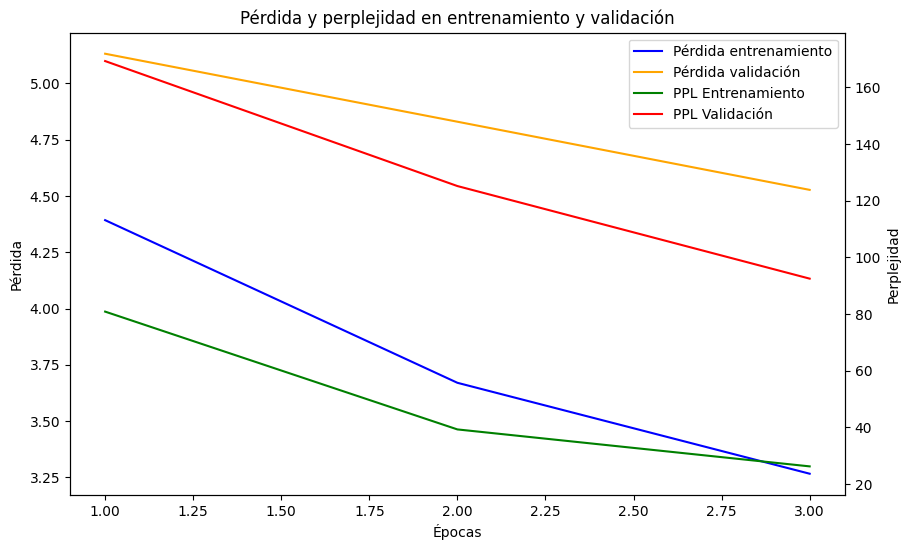

In [39]:
import matplotlib.pyplot as plt

# Crea una lista con los números de época
epochs = [epoch+1 for epoch in range(N_EPOCHS)]

# Crea la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()  # Crear un segundo eje y (comparten eje x)

# Grafica la pérdida de entrenamiento y validación
ax1.plot(epochs, train_losses, label='Pérdida entrenamiento', color='blue')
ax1.plot(epochs, valid_losses, label='Pérdida validación', color='orange')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Pérdida')
ax1.set_title('Pérdida y perplejidad en entrenamiento y validación')

# Grafica la perplejidad de entrenamiento y validación
ax2.plot(epochs, train_PPLs, label='PPL Entrenamiento', color='green')
ax2.plot(epochs, valid_PPLs, label='PPL Validación', color='red')
ax2.set_ylabel('Perplejidad')

# Ajusta la escala del eje y para el gráfico de perplejidad
ax2.set_ylim(bottom=min(min(train_PPLs), min(valid_PPLs)) - 10, top=max(max(train_PPLs), max(valid_PPLs)) + 10)

# Establece la leyenda combinando ambos ejes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')

# Muestra el gráfico
plt.show()



Se puede observar que la pérdida (*loss*) y la *perplejidad* disminuyen a medida que el modelo se entrena. La pérdida de validación comienza a estabilizarse y luego a aumentar  (¿en que época?) lo que sugiere que no es necesario continuar entrenando el modelo para evitar el *sobreentrenamiento* (*overtraining*).


#### Cargando el modelo guardado  

Si deseas omitir el entrenamiento y cargar el modelo preentrenado que se proporciona, simplemente descomenta la siguiente celda:

In [ ]:
# !wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/RNN-TR-model.pt'
# modelo.load_state_dict(torch.load('RNN-TR-model.pt',map_location=torch.device('cpu')))

#### Inferencia del modelo

A continuación, crea una función generadora que produzca traducciones para oraciones de entrada en el idioma fuente:


In [40]:
import torch.nn.functional as F

def generate_translation(modelo, src_sentence, src_vocab, trg_vocab, max_len=50):
    modelo.eval()  # Establece el modelo en modo evaluación

    with torch.no_grad():
        # Transforma la oración de entrada en un tensor de índices y la mueve al dispositivo
        src_tensor = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1).to(device)

        # Pasa el tensor de entrada por el codificador
        hidden, cell = modelo.encoder(src_tensor)

        # Crea una lista para almacenar la traducción generada
        # get_stoi() convierte tokens en índices
        trg_indexes = [trg_vocab.get_stoi()['<bos>']]  # Comienza con el token <bos>

        # Convierte el token inicial en un tensor de PyTorch
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1)  # Agrega dimensión de batch

        # Mueve el tensor al mismo dispositivo que el modelo
        trg_tensor = trg_tensor.to(modelo.device)

        # Genera la traducción
        for _ in range(max_len):

            # Pasa el último token generado junto con los estados hidden y cell anteriores al decodificador
            output, hidden, cell = modelo.decoder(trg_tensor[-1], hidden, cell)

            # Obtiene el índice del token más probable
            pred_token = output.argmax(1)[-1].item()

            # Agrega el token predicho a la lista de traducción
            trg_indexes.append(pred_token)

            # Si el token predicho es <eos>, se detiene la generación
            if pred_token == trg_vocab.get_stoi()['<eos>']:
                break

            # Convierte el token predicho en tensor para el siguiente paso
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1)  # Agrega dimensión de batch

            # Mueve el tensor al mismo dispositivo que el modelo
            trg_tensor = trg_tensor.to(modelo.device)

        # Convierte los índices generados en tokens de texto
        # get_itos() convierte índices en tokens
        trg_tokens = [trg_vocab.get_itos()[i] for i in trg_indexes]

        # Elimina <bos> y <eos> de la traducción
        if trg_tokens[0] == '<bos>':
            trg_tokens = trg_tokens[1:]
        if trg_tokens[-1] == '<eos>':
            trg_tokens = trg_tokens[:-1]

        # Devuelve la traducción como una cadena de texto
        translation = " ".join(trg_tokens)

        return translation


Ahora podemos verificar la salida del modelo para una oración de ejemplo:


In [41]:
# modelo.load_state_dict(torch.load('RNN-TR-model.pt'))

# Translacion actual: Asian man sweeping the walkway.
src_sentence = 'Ein asiatischer Mann kehrt den Gehweg.'


generated_translation = generate_translation(modelo, src_sentence=src_sentence, src_vocab=vocab_transform['de'], trg_vocab=vocab_transform['en'], max_len=12)
#Translacion generada = " ".join(generated_translation_list).replace("<bos>", "").replace("<eos>", "")
print(generated_translation)


An Asian man is on the sidewalk on the sidewalk .


Hemos creado un modelo de traducción que puede generar traducciones de alemán a inglés con bastante precisión.

> Ejercicio: Puedes experimentar con los parámetros y los hiperparámetros del modelo para mejorar su rendimiento.


#### Métrica BLEU para la evaluación

Mientras que la *perplejidad* sirve como una métrica general para evaluar el desempeño de un modelo de lenguaje en la predicción del siguiente token correcto, la puntuación BLEU es útil para evaluar la calidad de la traducción generada final.

Validar los resultados utilizando la métrica BLEU es útil cuando hay más de una traducción válida para una oración, ya que puedes incluir varias versiones de traducción en la lista de referencia y comparar la traducción generada con diferentes versiones posibles.

La puntuación BLEU (*Bilingual Evaluation Understudy*) es una métrica comúnmente utilizada para evaluar la calidad de las traducciones generadas por máquina, comparándolas con una o más traducciones de referencia. Mide la similitud entre la traducción generada y las traducciones de referencia basándose en la coincidencia de *n*-gramas.

La puntuación BLEU se calcula utilizando las siguientes fórmulas:


**1. Precisión**:
- La precisión mide la proporción de *n*-gramas en la traducción generada que aparecen en las traducciones de referencia.  
- La precisión se calcula para cada orden de *n*-gramas (de 1 a N) y luego se combina usando la media geométrica.  
- La precisión para un determinado orden *n* se calcula como:

$$
\text{Precisión}_n(t) = \frac{\text{CountClip}_n(t)}{\text{Count}_n(t)}
$$

Donde:
- $\text{CountClip}_n(t)$ es el conteo de *n*-gramas en la traducción generada que aparecen en alguna traducción de referencia, recortado por el número máximo de veces que ese *n*-grama aparece en una única traducción de referencia.
- $\text{Count}_n(t)$ es el conteo de *n*-gramas en la traducción generada.

**2. Penalización por brevedad (brevity penalty)**:
- La penalización por brevedad toma en cuenta el hecho de que las traducciones más cortas tienden a tener puntuaciones de precisión más altas.  
- Esta penalización favorece las traducciones cuya longitud sea más cercana a la de las traducciones de referencia.  
- Se calcula de la siguiente manera:

$$
\text{BP} = \begin{cases} 
1 & \text{si } c > r \\
e^{(1 - \frac{r}{c})} & \text{si } c \leq r 
\end{cases}
$$

Donde:
- $c$ es la longitud total de la traducción generada.  
- $r$ es la longitud total de las traducciones de referencia.

**3. Puntuación BLEU**:
- La puntuación BLEU es la media geométrica de las precisiones, ponderada por la penalización por brevedad.  
- Se calcula como:

$$
\text{BLEU} = \text{BP} \cdot \exp\left(\sum_{n=1}^{N}w_n \log(\text{Precision}_n(t))\right)
$$

Donde:
- $N$ es el orden máximo de *n*-gramas utilizado.  
- $w_n$ es el peso asignado a la precisión en el orden *n*, comúnmente definido como $\frac{1}{N}$ para pesos iguales.

In [ ]:
def calculate_bleu_score(generated_translation, reference_translations):
    # Convierte las traducciones generadas y las traducciones de referencia al formato esperado por `sentence_bleu`.
    references = [reference.split() for reference in reference_translations]
    hypothesis = generated_translation.split()

    # Calcula la puntuación BLEU 
    bleu_score = sentence_bleu(references, hypothesis)

    return bleu_score

Calculamos la puntuación BLEU para una oración de muestra:

In [ ]:
reference_translations = [
    "Asian man sweeping the walkway .",
    "An asian man sweeping the walkway .",
    "An Asian man sweeps the sidewalk .",
    "An Asian man is sweeping the sidewalk .",
    "An asian man is sweeping the walkway .",
    "Asian man sweeping the sidewalk ."
]

bleu_score = calculate_bleu_score(generated_translation, reference_translations)
print("Puntuacion BLEU:", bleu_score)

### **Ejercicios**

#### **1. Comparativa de arquitecturas recurrentes**

1. **RNN vs LSTM vs GRU (teórico y práctico)**  
   a) Explica brevemente (sin ecuaciones) qué problema solucionan LSTM y GRU frente a la RNN simple.  
   b) Implementa una red de predicción de la siguiente palabra (un modelo "language model") usando `nn.RNN`, `nn.LSTM` y `nn.GRU` con el mismo número de parámetros. Evalúa la *perplejidad* en un corpus pequeño (por ejemplo, fragmentos de novelas). ¿Qué arquitectura converge más rápido? ¿Cuál alcanza menor perplejidad?

2. **Ablación de componentes de LSTM**  
   – Toma tu implementación de LSTM y comenta (o deshabilita) cada una de sus puertas (entrada, olvido, salida). Por ejemplo, fuerza la puerta de olvido a 1.0 todo el tiempo. Mide el impacto en la pérdida y en la calidad de generación.

#### **2. Teacher Forcing**

3. **Efecto del ratio de teacher forcing**  
   – Entrena tu modelo Seq2Seq (RNN/LSTM) con distintos valores de `teacher_forcing_ratio`: 0.0, 0.5, 1.0.  
   – Grafica la pérdida de validación y la BLEU score para cada configuración. ¿Cómo afecta a la estabilidad del entrenamiento y a la calidad de generación al final?

4. **Scheduled Sampling**  
   – Implementa una versión de *scheduled sampling* en la que el ratio de teacher forcing decrece linealmente durante las épocas.  
   – Compara su evolución con la versión de ratio fijo. ¿Consigues menor discrepancia entre entrenamiento e inferencia ("exposure bias")?

#### **3. Estrategias de muestreo en decodificación**

5. **Greedy vs Sampling con temperatura**  
   – Dado un modelo entrenado, genera traducciones con:  
     a) **Greedy decoding** (siempre argmax).  
     b) **Muestreo multinomial** puro.  
     c) **Muestreo con temperatura**: implementa varias temperaturas `T ∈ {0.5, 1.0, 2.0}`.  
   – Analiza cómo cambian la fluidez y la diversidad de las oraciones generadas.

6. **Beam search**  
   – Implementa beam search con tamaño de beam `k = 3, 5`.  
   – Traduce un conjunto de oraciones y compara la BLEU score de cada beam.  
   – Justifica cuándo vale la pena usar beam search frente a greedy.

7. **Length penalty y coverage**  
   – Añade a tu beam search un factor de *length penalty* (para penalizar traducciones demasiado cortas o largas).  
   – Implementa también un término de *coverage* que penalice repetir fragmentos.  
   – Evalúa el efecto en perplejidad y BLEU.


#### **4. Mecanismo de atención**

8. **Atención punti-producto vs aditiva**  
   a) Implementa dos variantes de atención en tu Seq2Seq:  
      - Puntual (dot-product)  
      - Aditiva (Bahdanau)  
   b) Entrena ambos y compara:  
      - Calidad de traducción (BLEU).  
      - Velocidad de entrenamiento y atención visualizada (mapas de pesos para ejemplos).

9. **Visualización de pesos de atención**  
   – Para tres frases de prueba, grafica la matriz de atención `αₜₛ` (eje horizontal: tokens de la fuente; eje vertical: tokens generados).  
   – Interpreta: ¿se está alineando "correctamente" la atención?

10. **Self-Attention contra RNN-Attention**  
    – Sobre el mismo par de datos de traducción, adopta el bloque de atención interna (*self-attention*) de Transformer en lugar de la RNN + atención.  
    – Compara resultados y tiempos de inferencia en GPU.

#### **5. Arquitecturas Transformer**

11. **From Scratch: Encoder-Decoder Transformer**  
    – Crea un modelo Transformer básico (sin recurrencias) usando `nn.Transformer` de PyTorch.  
    – Entrénalo en Multi30k y compara la velocidad de convergencia con tu Seq2Seq RNN+Atención.

12. **Máscaras y positional encoding**  
    a) Explica en palabras la necesidad de máscaras (*padding mask*, *causal mask*).  
    b) Implementa tu propia capa de *positional encoding* senoidal sin usar el helper de PyTorch.  
    c) Observa qué ocurre si **no** añades ningún *positional encoding*.

13. **Fine-tuning y transfer learning**  
    – Utiliza un Transformer preentrenado (p. ej. `huggingface/transformers`) y ajústalo (fine-tune) en tu par de idiomas.  
    – Contrasta BLEU y tiempos de entrenamiento contra un modelo entrenado desde cero.


#### **6. Otras tareas Seq2Seq en NLP**

14. **Resumen automático**  
    – Adapta tu código de traducción para entrenar un modelo de resumen extractivo/abstractive en CNN/DailyMail.  
    – Compara *ROUGE-1*, *ROUGE-2* y *ROUGE-L* de ambos enfoques.

15. **Paráfrasis y estilo**  
    – Entrena un Seq2Seq para convertir oraciones en voz activa a pasiva (o viceversa) usando un dataset sintético.  
    – Introduce *teacher forcing*, beam search y sampling con temperatura. Observa cómo varía la corrección gramatical y la diversidad.

16. **Diálogo (chatbot simple)**  
    – Recopila pares `([saludo, pregunta], respuesta)` de un subconjunto reducido de un dataset de diálogo.  
    – Entrena un modelo Seq2Seq + atención que, dado el historial de la conversación, prediga la siguiente respuesta.  
    – Mide coherencia (p.ej. human eval) y tasa de repetición de frases.

17. **Traducción multimodal**  
    – Incorpora características de imágenes (extraídas de CNN preentrenada) como vectores de contexto adicionales al codificador textual, para traducir descripciones de escenas.


In [ ]:
### Tus respuestas